In [ ]:
#loading all the necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm.notebook import tqdm #useful module for progress bars
import logging
import gc
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

In [ ]:
#here this is a function for loading the images from a given directory.
def load_all_images(directory, img_size = False, range_from = 0, range_to = 1):
    filenames = os.listdir(directory)
    num = len(filenames)
    resize = True
    if(not img_size):
        img = cv2.imread(os.path.join(directory,filenames[0]))
        img_size = img.shape[0]
        resize = False
    #For memory sizes this big dinamyc arrays (lists) are not an effective way to reserve memory
    #Hence numpy arrays are utalized
    print(f"{int(num*(range_to-range_from))} files to be loaded")
    start = int(num*range_from)
    images = np.zeros(shape=(int(num*(range_to-range_from)), img_size, img_size, 3), dtype=np.float16)
    w = 100
    num_none = 0
    for i in tqdm(range(int(images.shape[0]))):
        img = cv2.imread(os.path.join(directory,filenames[i+start]))
        if img is not None:

            if(resize):
                images[i, ...] = cv2.resize(img, (img_size, img_size))
            else:
                images[i, ...] = img
            '''
            w-=1
            if(__debug__ and w==0):
                break
        else:
            num_none +=1
'''
    if(num_none>0):
        print(f"{num_none} images were unable to load, or not valid image types")
    return images
#Here we used the garbage collector library to collect the pictures into a npz dataformat.
#we are splitting it into multiple batches and making the images 128x128 sizes.
#This way we are reserving memory and it's easier to load this later.
gc.collect()
np.savez("train_128x128_1_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0,
 range_to=0.25)
 )
gc.collect()
np.savez("train_128x128_2_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0.25,
 range_to=0.5)
 )
gc.collect()
np.savez("train_128x128_3_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0.5,
 range_to=0.75)
 )
gc.collect()
np.savez("train_128x128_4_of_4.npz", train=load_all_images("train",
img_size=128,
range_from=0.75,
 range_to=1)
 )
gc.collect()
np.savez("val_128x128.npz", val=load_all_images("val",
img_size=128)
 )


21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

21686 files to be loaded


  0%|          | 0/21686 [00:00<?, ?it/s]

10954 files to be loaded


  0%|          | 0/10954 [00:00<?, ?it/s]

In [ ]:
#here we are dispalying the time and loading one of the arrays.
now = datetime.now()
this_data = np.load("train_128x128_1_of_4.npz")["train"]
print(datetime.now()-now)

0:00:52.311926


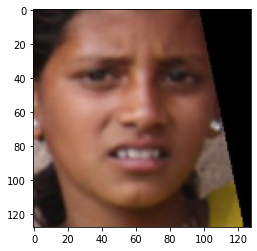

In [ ]:
#Here we show one of the images to make sure everything is working
plt.imshow((this_data[10000][:, :, ::-1]).astype(float)/255.0) #for some reason the RGB is reversed
plt.show()

In [ ]:
#reading the csv file that contains the labels with pandas
train_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/train.csv")
val_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/val.csv")

In [ ]:
#displaying the training labels
train_label_raw.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [ ]:
#dispalying the validation labels
val_label_raw.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


In [ ]:
#Here we used sklearn in order to onehotencode our data thus preparing it for the CNN network
OHEC =OneHotEncoder()
"""
OHEC.fit(X=[["0-2", "Male", "Black", "False"],["3-9", "Female", "Indian", "True"],
["10-19", "Male", "East Asian", "False"],["20-29", "Male", "Southeast Asian", "False"],
["30-39", "Male", "Latino_Hispanic", "False"],["40-49", "Male", "Middle Eastern", "False"],["50-59", "Male", "White", "False"],
["60-69", "Male", "Middel Eastern", "False"],["more than 70", "Male", "White", "False"]])
"""
#The one hot encoder arranges the inputs in alphabetic order
OHEC.fit(val_label_raw[["age", "gender", "race", "service_test"]])
val_label = OHEC.transform(val_label_raw[["age", "gender", "race", "service_test"]]).toarray()
train_label = OHEC.transform(train_label_raw[["age", "gender", "race", "service_test"]]).toarray()
#We are putting thes together inside this npz dataformat
np.savez("labels.npz", train=train_label, val=val_label)

In [ ]:
labels=np.load("labels.npz")

In [ ]:
#Here we are defining the image generetor so that we can use it in our network
#this weill rotate, shear and flip the image so we have more datapoints to use
datagen=ImageDataGenerator(rotation_range=45, width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2, zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode="constant", cval=128 )

In [ ]:
#We first create a directory
#here we created 5 modified pictures in order to plot them.
#later we will use the image generator in our model as stated before.
!mkdir "modified"
pictures=datagen.flow(this_data[0:5], save_to_dir="[modified]", save_prefix="aug",save_format="png")

In [ ]:
#This function will loadd the images in a given directory
dir_ect=("[modified]")
def load_all_images(directory):
    images = []
    for filename in tqdm(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory,filename))
        if img is not None:
            images.append(img)
    return images

images = load_all_images(dir_ect)       
print(len(images))

  0%|          | 0/11 [00:00<?, ?it/s]

11


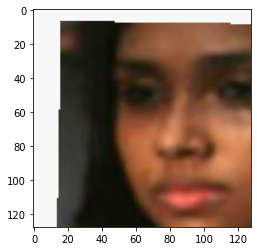

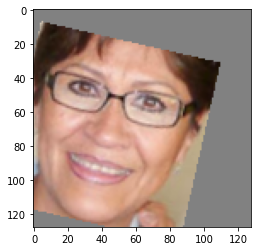

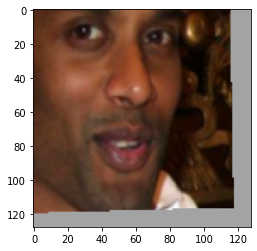

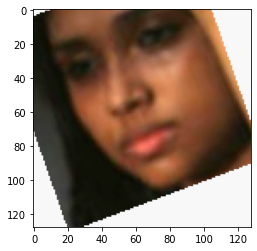

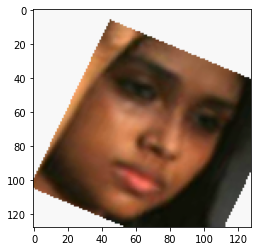

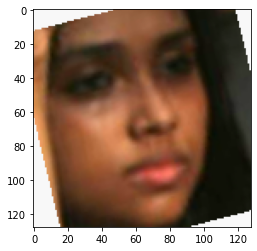

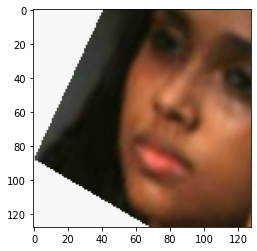

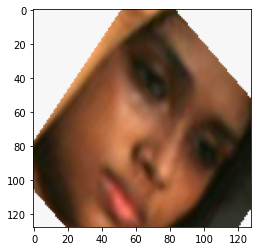

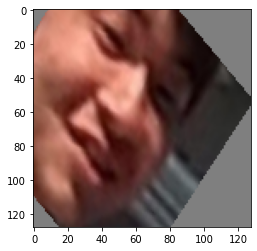

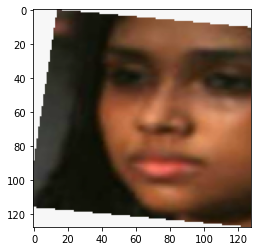

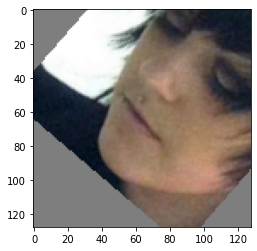

In [ ]:
#lastly this for loop will plot the images inside the loaded images
for i in range(len(images)):
  plt.imshow(images[i])
  plt.show()